In [1]:
import numpy as np
from scipy import interpolate

length = 435.5 / 100  # 经过的总长度

rou_panel = 1859  # 电路板密度
thick_panel = 0.0015  # 焊接区域厚度

# 电路板比热容三次样条插值
x_temp_panel = [20, 80, 120, 160, 200, 225, 240, 260, 280]
cp_panel = [1100, 1400, 1500, 1550, 1600, 1610, 1640, 1665, 1690]
f_panel_cp = interpolate.interp1d(x_temp_panel, cp_panel, kind='cubic')

# 空气各项指标随温度变化插值
x_temp_air = [20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 250, 300, 350]

# 动力粘度插值
eta_air = [1.81e-5, 1.86e-5, 1.91e-5, 1.96e-5, 2.01e-5, 2.06e-5, 2.11e-5, 2.15e-5,
           2.19e-5, 2.28e-5, 2.37e-5, 2.45e-5, 2.53e-5, 2.6e-5, 2.74e-5, 2.97e-5, 3.14e-5]
f_air_eta = interpolate.interp1d(x_temp_air, eta_air, kind='cubic')

# 导热系数插值
lamb_air = [2.593e-2, 2.675e-2, 2.756e-2, 2.826e-2, 2.896e-2, 2.966e-2, 3.047e-2, 3.128e-2,
            3.21e-2, 3.338e-2, 3.489e-2, 3.64e-2, 3.78e-2, 3.931e-2, 4.268e-2, 4.605e-2, 4.908e-2]
f_air_lamb = interpolate.interp1d(x_temp_air, lamb_air, kind='cubic')

# 定压比热容插值
cp_air = [1013, 1013, 1013, 1017, 1017, 1017, 1022, 1022, 1022, 1026,
          1026, 1026, 1034, 1034, 1043, 1047, 1055]
f_air_cp = interpolate.interp1d(x_temp_air, cp_air, kind='cubic')

# 流体粘度插值
u_air = [1.502e-5, 1.597e-5, 1.693e-5, 1.793e-5, 1.869e-5, 2.002e-5, 2.11e-5, 2.212e-5,
         2.315e-5, 2.539e-5, 2.775e-5, 3.006e-5, 3.248e-5, 3.485e-5, 4.065e-5, 4.829e-5, 5.548e-5]
f_air_u = interpolate.interp1d(x_temp_air, u_air, kind='cubic')


# T-air, 炉内空气温度
def T_air(v_, t_, t1_, t2_, t3_, t4_):
    air_list = []
    way = v_ * t_
    for w in way:
        if 0.0 <= w < 0.25:
            air_list.append((t1_ - 25) / 0.25 * w + 25)
        elif 0.25 <= w < 1.975:
            air_list.append(t1_)
        elif 1.975 <= w < 2.025:
            air_list.append((t2_ - t1_) / 0.05 * w - (t2_ - t1_) / 0.05 * 1.975 + t1_)
        elif 2.025 <= w < 2.33:
            air_list.append(t2_)
        elif 2.33 <= w < 2.38:
            air_list.append((t3_ - t2_) / 0.05 * w - (t3_ - t2_) / 0.05 * 2.33 + t2_)
        elif 2.38 <= w < 2.685:
            air_list.append(t3_)
        elif 2.685 <= w < 2.935:
            air_list.append((t4_ - t3_) / 0.05 * w - (t4_ - t3_) / 0.05 * 2.685 + t3_)
        elif 2.935 <= w < 3.395:
            air_list.append(t4_)
        elif 3.395 <= w < 4.105:
            air_list.append((25 - t4_) / 0.7 * w - (25 - t4_) / 0.7 * 3.395 + t4_)
        else:
            air_list.append(25)
    return np.array(air_list)


# 计算hc，对流热传导率
def calculate_hc(temp_, gama_=None):
    return 0.664 * np.power(gama_, 0.5) * \
           np.power(f_air_eta(temp_) * f_air_cp(temp_), 1 / 3) * \
           np.power(f_air_lamb(temp_), 2 / 3) / np.power(f_air_u(temp_), 0.5)


# 计算求解偏导数
def calculate_ds(hc_, k_, t_air_, temp_):
    yz = hc_ + k_ * (np.square(t_air_) + np.square(temp_)) * (t_air_ + temp_)
    return yz * (t_air_ - temp_) * (1 / (rou_panel * f_panel_cp(temp_) * thick_panel))


class CalculateEquation:
    def __init__(self):
        self.max_temp = None
        self.max_ds = None
        self.time_in_150190 = None
        self.time_high217 = None

    # 求解最大速度
    def solve_max_velocity(self,  gama=312, v_=None, t1_=None, t2_=None, t3_=None, t4_=None):
        v_ = v_ / 6000  # 转换单位
        second_max = int(length / v_)
        time_list = np.arange(0, second_max + 0.5, 0.5)
        temp_list = [25]
        ds_list = []
        t_air_list = T_air(v_, time_list, t1_, t2_, t3_, t4_)
        t_air_list_h2 = T_air(v_, time_list + 0.25, t1_, t2_, t3_, t4_)
        K = (5.669e-8 * 0.8 * 0.98) / (0.8 + 0.98 - 1)

        # 龙格库塔法求解
        for i in range(len(time_list) - 1):
            hc = calculate_hc(temp_list[i], gama_=gama)
            k1 = calculate_ds(hc, K, t_air_list[i], temp_list[i])
            k2 = calculate_ds(hc, K, t_air_list_h2[i], temp_list[i] + 0.25 * k1)
            k3 = calculate_ds(hc, K, t_air_list_h2[i], temp_list[i] + 0.25 * k2)
            k4 = calculate_ds(hc, K, t_air_list[i + 1], temp_list[i] + 0.5 * k3)
            ds_list.append(k1)
            temp_list.append(temp_list[i] + 0.5 / 6 * (k1 + 2 * k2 + 2 * k3 + k4))

        # 计算限制条件
        temp_list = np.array(temp_list)
        self.max_temp = np.max(temp_list)  # 最大温度
        self.max_ds = np.max(np.absolute(ds_list))  # 最大斜率

        # 计算两个时间限制
        try:            # 此处考虑到优化过程中温度过高或过低导致两个限制时间为0无法进行减法计算
            self.time_in_150190 = time_list[temp_list >= 190][0] - time_list[temp_list >= 150][0]
        except :
            self.time_in_150190 = 20
        try:
            self.time_high217 = time_list[temp_list > 217][-1] - time_list[temp_list > 217][0]
        except :
            self.time_high217 = 20

        # 检查限制条件，符合则输出结果，结束程序
        if (240 <= self.max_temp <= 250 and
                self.max_ds <= 3 and 60 <= self.time_in_150190 <= 120 and
                40 <= self.time_high217 <= 90):
            # print('最大速度为：{} cm/min'.format(v_ * 6000))
            # print('最大温度：', self.max_temp)
            # print('斜率最大值：', self.max_ds)
            # print('温度高于217度的总时间：', self.time_high217)
            # print('上升期间，温度处于150度-190度的总时间：', self.time_in_150190)
            return v_ * 6000
        return 0

question_model = CalculateEquation()
v_list = np.arange(65, 101, 0.5)
v_list = list(v_list)
v_list.reverse()
print('正在求解最大速度...')
t1_list = np.arange(-5, 5, 0.5)
t2_list = np.arange(-5, 5, 0.5)
t3_list = np.arange(-5, 5, 0.5)
t4_list = np.arange(-5, 5, 0.5)

t1_v = []
t2_v = []
t3_v = []
t4_v = []

for t1 in t1_list:
    for v in v_list:
        bv = question_model.solve_max_velocity(v_=v, t1_=t1 + 182, t2_=203, t3_=237, t4_=254)
        if bv:
            t1_v.append(bv)
            break
    else:
        t1_v.append(0)

for t2 in t2_list:
    for v in v_list:
        bv = question_model.solve_max_velocity(v_=v, t1_=182, t2_=t2 + 203, t3_=237, t4_=254)
        if bv:
            t2_v.append(bv)
            break
    else:
        t2_v.append(0)

for t3 in t3_list:
    for v in v_list:
        bv = question_model.solve_max_velocity(v_=v, t1_=182, t2_=203, t3_=t3 + 237, t4_=254)
        if bv:
            t3_v.append(bv)
            break
    else:
        t3_v.append(0)

for t4 in t4_list:
    for v in v_list:
        bv = question_model.solve_max_velocity(v_=v, t1_=182, t2_=203, t3_=237, t4_=t4 + 254)
        if bv:
            t4_v.append(bv)
            break
    else:
        t4_v.append(0)

正在求解最大速度...


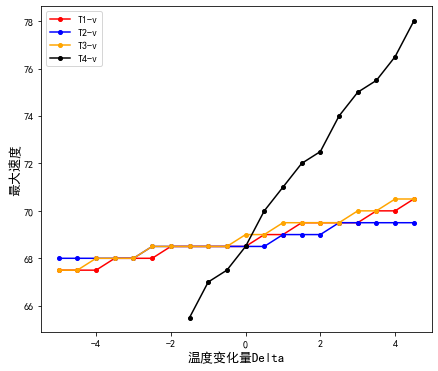

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
t4_v = np.array(t4_v)
t3_v.reverse()
plt.figure(figsize=(7, 6))
plt.plot(t1_list, t1_v, color='r', marker='o', markersize=4, label='T1-v')
plt.plot(t2_list, t2_v, color='b', marker='o', markersize=4, label='T2-v')
plt.plot(t3_list, t3_v, color='orange', marker='o', markersize=4, label='T3-v')
plt.plot(t4_list[t4_v > 0], t4_v[t4_v > 0], color='black', marker='o', markersize=4, label='T4-v')
plt.xlabel('温度变化量Delta', fontdict={'size': 13})
plt.ylabel('最大速度', fontdict={'size': 13})
plt.legend()
plt.savefig('温度速度灵敏度.png')
plt.show()
